# Home Assigment 2, CMPE 252, Section 02, Spring 2022.

## Question 2: MDP in the continuous case.
In this question you will solve MDP with an infinite planning horizon for the dynamical system of Cart-Pole. Specifically, you will numerically solve the Riccati equation, derive the optmal value function and the optimal state feedback policy, $\pi^*(s)$, and stabilize the pole at the upright position at a predefined target location of the cart.  

###  Cart-Pole Dynamical System
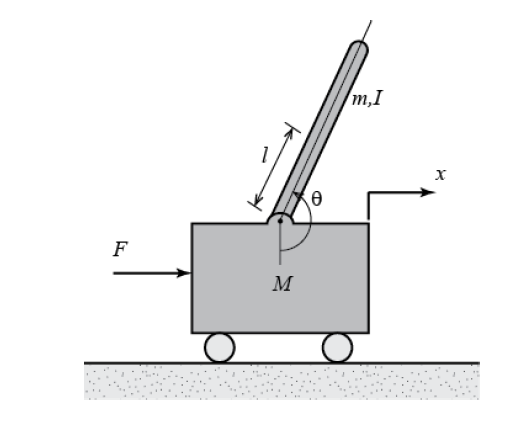

The cart-pole problem, which is an inverted pendulum on a cart, is a classical benchmark problem for sequential decision making in continous domain. It is an inherently unstable and underactuated mechanical system. The agent controls the cart only, rather than the full state space of cart+pole. This mean 'underactuated system'. 

The dynamics of this system is used to understand tasks involving the maintenance of balance, such as walking, control of rocket thrusters and self-balancing mechanical systems.

The objective in this problem is to balance the pole around the top as long as possible. 


This problem is formuated as MDP in continuous state space and action space with an infinite planning horizon. 

#### Parameters:

a. **mass of the cart**, M : 1kg

b. **mass of the pole**, m : 0.3kg

c. **friction coefficient of the cart**, b : 0.1N/m/sec

d. **length of the pole**, l : 1m

e. **inertia of the pole**, $I$ : 0.001 kg m<sup>2</sup> 

f. **simulation step time**, (dt): 0.01 sec

#### Variables:

a. **Force applied to the cart at time $k$**: $F_k$

b. **Cart position at time $k$**: $x_k$

c. **Cart velocity at time $k$**: $\dot{x}_k$

d. **Pendulum angle from the upright position at time $k$**: $\phi_k$ ($\theta$ and $\phi$ are connected by $\theta=\pi + \phi$).

e. **Pendulum anglular velocity at time $k$**: $\dot{\phi}_k$

#### State at time $k$:
$s_k = [x_k, \dot{x}_k, \phi_k, \dot{\phi}_k]$

#### Target state $s[T]$:
the goal is to stabilize the pole at the upright position, $\phi\approx 0$, at $x=0m$ with $\dot{x}$

In [1]:
# Importing packages
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv

In [2]:
# Initialization of Model Parameters
M = 1   #Mass of the cart 
m = 0.3 #Mass of the poll
b = 0.1 # friction of the cart
I = 0.001# Intertia  
g = 9.8 # Gravity
l = 1   # length of the pole
dt = 0.01 # Step time

#### Equations of motion, EOM, Cart-Pole (provided for completeness, you do not need them for solution):

$$(l+ml^{2})\ddot{\theta} + mgl sin(\theta) = - ml\ddot(x) cos(\theta)$$ 
$$(M + m)(\ddot{x}) + b\dot{x} + ml\ddot(\theta)cos(\theta) - ml\dot{\theta}^{2} sin(\theta) = F$$

#### Linearized EOM of Cart-Pole
We linearise EOM around the upright position, θ = π, where φ is the angle measured from the upright position, (θ = π + φ), and discretize time with the time stepl $dt=0.01sec$

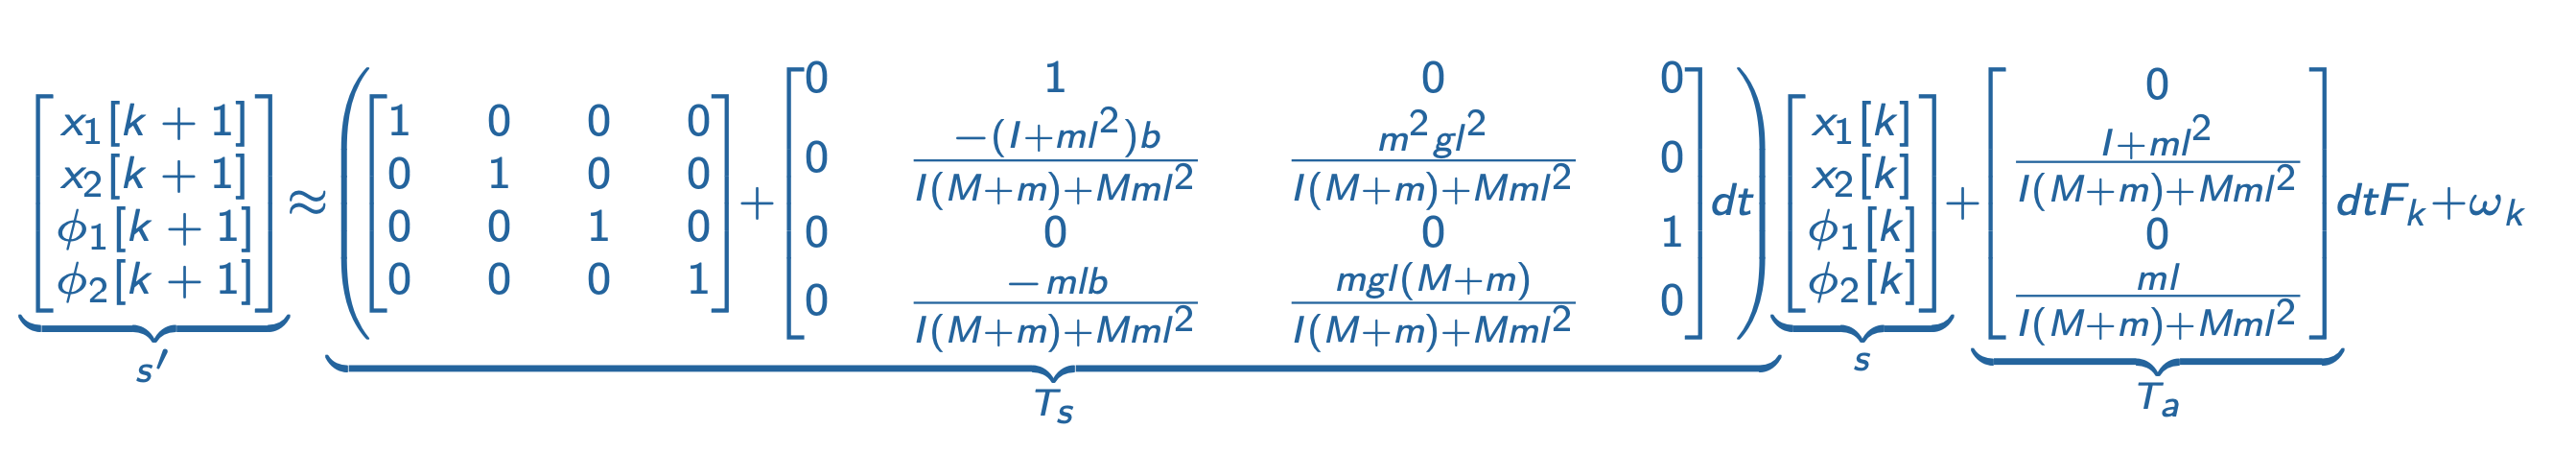

The linearized systems appears as:
$$s[k+1] = T_s s[k] + T_a F[k] + \omega[k]\;(***)$$ with $\omega \sim \mathcal{N}(0,\,{\Sigma})$ , $\Sigma = \sigma \times I_{4 \times 4}$ with $\sigma=0.01$.




## Reward is Given by Equation
$$R= s^{T}R_{x}s  + F^TR_{a}F, $$
where $s = [x, \dot{x}, \phi, \dot{\phi}]_{4\times 1}$, $s^T = [x; \dot{x}; \phi; \dot{\phi}]_{1\times 4}$, and $F$ is a scalar force applied to the cart. (in the case of scalar force, the second term in $R$ can be written as $R_aF^2$)

### where $R_s$ is
$$ R_{s} = - \begin{pmatrix}
\rho/10 & 0 & 0 & 0\\
0 & \rho/10 & 0 & 0 \\
0 & 0 & \rho & 0 \\
0 & 0 & 0 & \rho/5\\
\end{pmatrix},
$$ $\rho$ (Rho) is a positive constant, and $ R_{a} = -3$. 

#### Task 1  
Form the transition matrix, $T_s$,  the control gain, $T_a$, and the reward, $R(s, a)=R_s + R_a$ matrix for the Linearised EOM

In [3]:
div = (I * (M+m)) + (M * m * l * l)
a = ((I + (M * l * l)) * b * (-1)) / div
b = (m*m*g*l*l) / div
c = (m * l * b * (-1)) / div
d = ((m * g * l) * (m + M)) / div
e = (I + (M * l * l)) / div
f = (m * l) / div
a = round(a,3)
b = round(b,3)
c = round(c,3)
d = round(d,3)
e = round(e,3)
f = round(f,3)

Ts = np.identity(4) + (np.matrix([[0, 1, 0, 0],[0, a, b, 0],[0, 0, 0, 1],[0, c, d, 0]]) * dt)
print(Ts) 
Ta = np.matrix([[0],[e],[0],[f]]) * dt
print(Ta)
Rho = 50
Rs = (-1) * np.matrix([[Rho/10, 0, 0, 0],[0, Rho/10, 0, 0],[0, 0, Rho, 0],[0, 0, 0, Rho/5]])
Ra = [[-3]]

[[ 1.       0.01     0.       0.     ]
 [ 0.       0.99668  0.02927  0.     ]
 [ 0.       0.       1.       0.01   ]
 [ 0.      -0.02915  0.12685  1.     ]]
[[0.     ]
 [0.03322]
 [0.     ]
 [0.00996]]


#### Task 2 
Solve iteratively the Riccati equation for $V_k$, find the linear state feedback matrix $L_k$, and the optimal force, $F_k^{lqr}$ as explained at the below pseudo code. The first loop calculates $V_k$ backward in time. While the second loop is the calculation of the linear state feedback, $L_k$, and the optimal force, $F^{lqr}_k$, respectively. 'Trace' is the sum of diagonal elements of a matrix, cf., 'numpy.trace'.
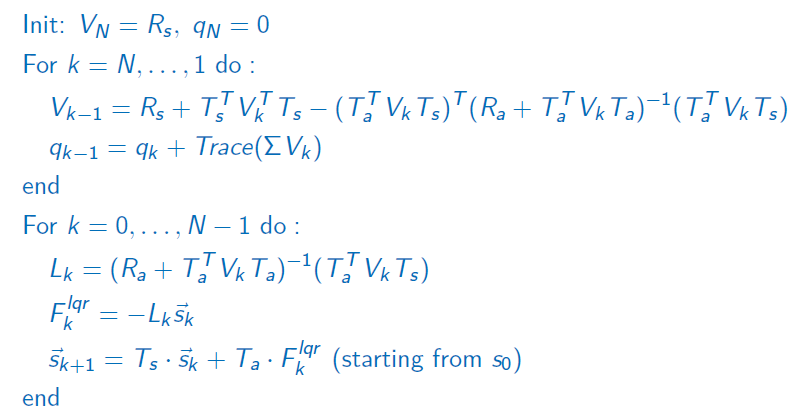
with $ s_0 = [0.1,+0.05,0.1,0.02]_{4\times 1}$, the meaning of the initial conditions is as follows. The cart start $0.1 m$ from the targer location, and moves in the opposite direction with velocity $0.05m/s$. The pole starts $0.1rad$ from the vertical (upright) with angular velocity of $0.02$. Obvisously, the pole will fall to the bottom without a policy, which will stabililze it aroun the top. 

In [15]:
N = 1000

sigma = 1
noise_sd=np.identity(4)*sigma
noise = np.random.normal(0,sigma,4)

In [24]:
V=dict()
q=dict()
V[N]=Rs
q[N]=0
Tst = Ts.transpose()
Tat = Ta.transpose()

## solution of Riccati equation
for k in range(N,1,-1): 
    Vkt = V[k].transpose()
    x1 = np.matmul(Tst,np.matmul(Vkt,Ts))
    b1 = np.matmul(Tat,np.matmul(V[k],Ts))
    b1t = b1.transpose()
    c1 = inv(Ra + np.matmul(Tat,np.matmul(V[k],Ta)))
    d1 = np.matmul(Tat,np.matmul(V[k],Ts))
    y1 = np.matmul(b1t,np.matmul(c1,d1))
    V[k-1] = Rs + x1 - y1
    q[k-1] = q[k] + np.trace(np.matmul(noise_sd,V[k]))
L = dict()
F = dict()
S = dict()
S[1] = np.matrix([[0.1],[0.05],[0.1],[0.02]])
## finding the optimal force and stabilazing the pole
for k in range(1,N+1):
    a2 = inv(Ra + np.matmul(Ta.transpose(),np.matmul(V[k],Ta)))
    b2 = np.matmul(Ta.transpose(),np.matmul(V[k],Ts))
    L[k]   = np.matmul(a2,b2)
    F[k]   = np.matmul(L[k],S[k]) * (-1)
    S[k+1] = np.matmul(Ts,S[k]) + np.matmul(Ta,F[k]) + noise
def cal_S(noise):
    for k in range(1,N+1):
        a2 = inv(Ra + np.matmul(Ta.transpose(),np.matmul(V[k],Ta)))
        b2 = np.matmul(Ta.transpose(),np.matmul(V[k],Ts))
        L[k]   = np.matmul(a2,b2)
        F[k]   = np.matmul(L[k],S[k]) * (-1)
        S[k+1] = np.matmul(Ts,S[k]) + np.matmul(Ta,F[k]) + noise


#### Task 3
Visualize Value Function, $U(s)$ for cart pole, $U^*(s) = s^TV_0s + q_0$ for $x=0 m$, $\dot{x}=0 m/s$, $\phi\in [-0.2, +0.2]rad$, and $\phi\in [-0.2, +0.2]rad$

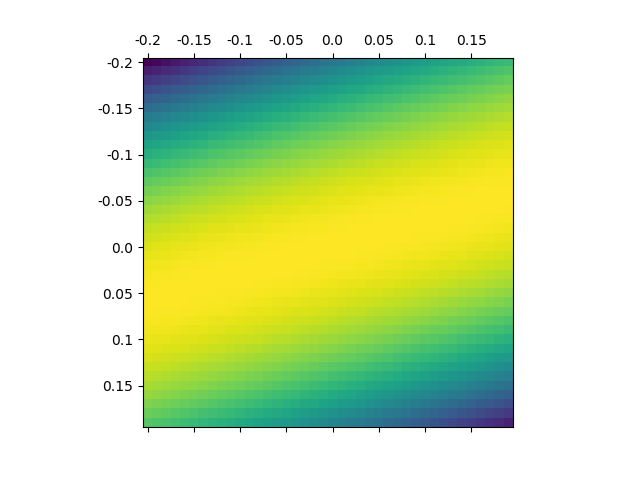

In [36]:
U = np.zeros((40,40))
i = 0
fig = plt.figure()
ax = fig.add_subplot(111)
phi_a = []
for phi in np.arange(-0.2,0.2,0.01) :
    phi = round(phi,2)
    phi_a.append(phi)
    j = 0
    for phi_dot in np.arange(-0.2,0.2,0.01) :
        phi_dot = round(phi_dot,2)
        s=np.matrix([[0],[0],[phi],[phi_dot]])
        U[i,j] = np.matmul(s.transpose(),np.matmul(V[1],s)) + q[1]
        j+=1
    i+=1
ax.set_xticks(np.arange(len(phi_a))) 
ax.set_yticks(np.arange(len(phi_a)))
ax.set_xticklabels(phi_a)
ax.set_yticklabels(phi_a)
cax = ax.matshow(U)
plt.show()

#### Task 4 
Produce 4 subplots: $x[k]$, $\dot{x}[k]$, $\phi[k]$, and $\dot{\phi}[k]$ as a function of $k$ for $k\in [1, 500]$. On each subplot visualize 5 trajectories starting from $s_0$. E.g., 5 trajectories of $x[k]$ on subplot(1, 1). They can be different at the level of a single sample due to $\omega[k]$ in $(***)$, but they should be qualitatively similar.

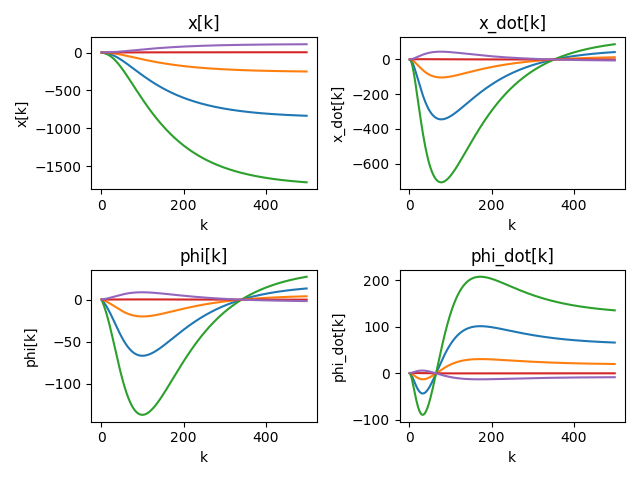

In [42]:
y = list(range(1,500,1))

fig, axs= plt.subplots(2,2)
ax = axs[0,0]
bx = axs[0,1]
cx = axs[1,0]
dx = axs[1,1]



for i in range(0,5):
    noise = np.matrix(np.random.normal(0,sigma,4))
    cal_S(noise)
    x = [S[i][0,0] for i in y]
    x_dot = [S[i][1,0] for i in y]
    phi = [S[i][2,0] for i in y] 
    phi_dot = [S[i][3,0] for i in y]
    ax.plot(y,x)
    bx.plot(y,x_dot)
    cx.plot(y,phi)
    dx.plot(y,phi_dot)
    ax.set_title("x[k]")
    ax.set_ylabel("x[k]")
    ax.set_xlabel("k")
    bx.set_title("x_dot[k]")
    bx.set_ylabel("x_dot[k]")
    bx.set_xlabel("k")
    cx.set_title("phi[k]")
    cx.set_ylabel("phi[k]")
    cx.set_xlabel("k")
    dx.set_title("phi_dot[k]")
    dx.set_ylabel("phi_dot[k]")
    dx.set_xlabel("k")
plt.tight_layout()
plt.show()

#### Task 5 
Plot "$\dot{x}$ vs $x$" and "$\dot{\phi}$ vs $\phi$", (where $A$ vs $B$ means A is on the y-axis and B is on the x-axis). As in Task 4 visualize 5 trajectiories at $\dot{x}$ vs $x$ and 5 trajectiories at $\dot{\phi}$ vs $\phi$. 

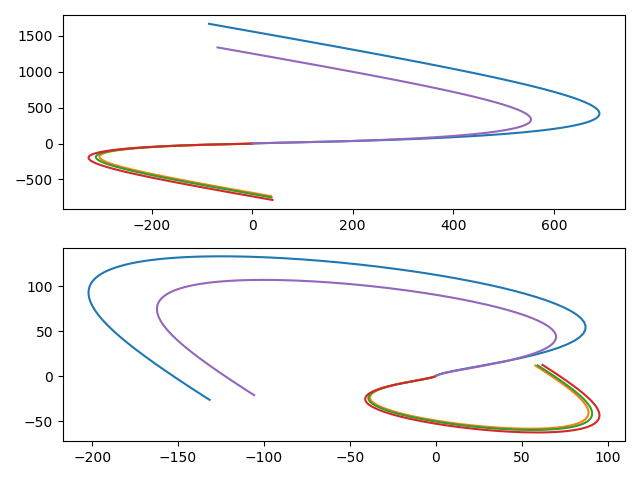

In [43]:
fig, axs= plt.subplots(2)
ax = axs[0]
bx = axs[1]
for i in range(0,5):
    noise = np.matrix(np.random.normal(0,sigma,4))
    cal_S(noise)
    x = [S[i][0,0] for i in y]
    x_dot = [S[i][1,0] for i in y]
    phi = [S[i][2,0] for i in y] 
    phi_dot = [S[i][3,0] for i in y]
    ax.plot(x_dot,x)
    bx.plot(phi_dot,phi)

plt.tight_layout()
plt.show()

In [44]:
def repeate_it(Rho,sigma_1):
    Rs = (-1) * np.matrix([[Rho/10, 0, 0, 0],[0, Rho/10, 0, 0],[0, 0, Rho, 0],[0, 0, 0, Rho/5]])
    V[N]=Rs
    sigma = sigma_1
    noise_sd=np.identity(4)*sigma
    noise = np.random.normal(0,sigma,5)
    
    for k in range(N,1,-1): 
        Vkt = V[k].transpose()
        x1 = np.matmul(Tst,np.matmul(Vkt,Ts))
        b1 = np.matmul(Tat,np.matmul(V[k],Ts))
        b1t = b1.transpose()
        c1 = inv(Ra + np.matmul(Tat,np.matmul(V[k],Ta)))
        d1 = np.matmul(Tat,np.matmul(V[k],Ts))
        y1 = np.matmul(b1t,np.matmul(c1,d1))
        V[k-1] = Rs + x1 - y1
        q[k-1] = q[k] + np.trace(np.matmul(noise_sd,V[k]))
    L = dict()
    F = dict()
    S = dict()
    S[1] = np.matrix([[0.1],[0.05],[0.1],[0.02]])
    ## finding the optimal force and stabilazing the pole
    def cal_S(noise):
        for k in range(1,N+1):
            a2 = inv(Ra + np.matmul(Ta.transpose(),np.matmul(V[k],Ta)))
            b2 = np.matmul(Ta.transpose(),np.matmul(V[k],Ts))
            L[k]   = np.matmul(a2,b2)
            F[k]   = np.matmul(L[k],S[k]) * (-1)
            S[k+1] = np.matmul(Ts,S[k]) + np.matmul(Ta,F[k]) + noise
            
            
            
    U = np.zeros((40,40))
    i = 0
    fig = plt.figure()
    ax = fig.add_subplot(111)
    phi_a = []
    for phi in np.arange(-0.2,0.2,0.01) :
        phi = round(phi,2)
        phi_a.append(phi)
        j = 0
        for phi_dot in np.arange(-0.2,0.2,0.01) :
            phi_dot = round(phi_dot,2)
            s=np.matrix([[0],[0],[phi],[phi_dot]])
            U[i,j] = np.matmul(s.transpose(),np.matmul(V[1],s)) + q[1]
            j+=1
        i+=1
    ax.set_xticks(np.arange(len(phi_a))) 
    ax.set_yticks(np.arange(len(phi_a)))
    ax.set_xticklabels(phi_a)
    ax.set_yticklabels(phi_a)
    cax = ax.matshow(U)
    plt.show()        
    
    
    
    y = list(range(1,500,1))
    fig, axs= plt.subplots(2,2)
    ax = axs[0,0]
    bx = axs[0,1]
    cx = axs[1,0]
    dx = axs[1,1]



    for i in range(0,5):
        noise = np.matrix(np.random.normal(0,sigma,4))
        cal_S(noise)
        x = [S[i][0,0] for i in y]
        x_dot = [S[i][1,0] for i in y]
        phi = [S[i][2,0] for i in y] 
        phi_dot = [S[i][3,0] for i in y]
        ax.plot(y,x)
        bx.plot(y,x_dot)
        cx.plot(y,phi)
        dx.plot(y,phi_dot)
        ax.set_title("x[k]")
        bx.set_title("x_dot[k]")
        cx.set_title("phi[k]")
        dx.set_title("phi_dot[k]")
    plt.tight_layout()
    plt.show()
    fig, axs= plt.subplots(2)
    ax = axs[0]
    bx = axs[1]
    for i in range(0,5):
        noise = np.matrix(np.random.normal(0,sigma,4))
        cal_S(noise)
        x = [S[i][0,0] for i in y]
        x_dot = [S[i][1,0] for i in y]
        phi = [S[i][2,0] for i in y] 
        phi_dot = [S[i][3,0] for i in y]
        ax.plot(x_dot,x)
        bx.plot(phi_dot,phi)

    plt.tight_layout()
    plt.show()

#### Task 6
Repeat Tasks 1-5 for $\rho \in \{20,50\}$, explain your observations.

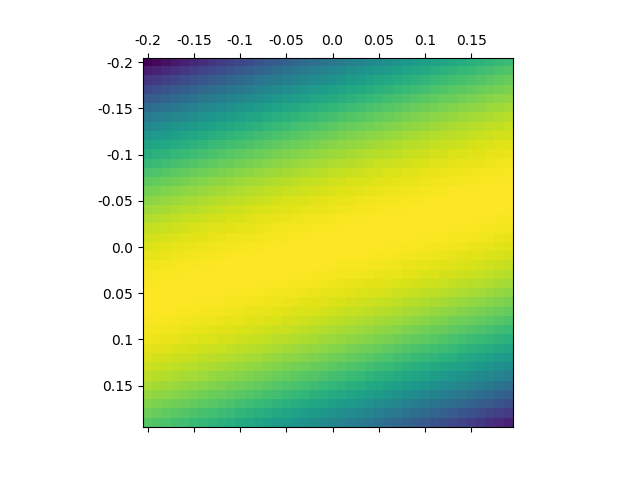

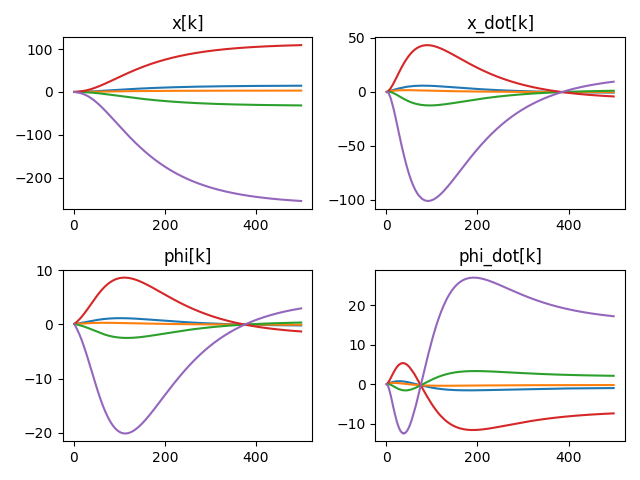

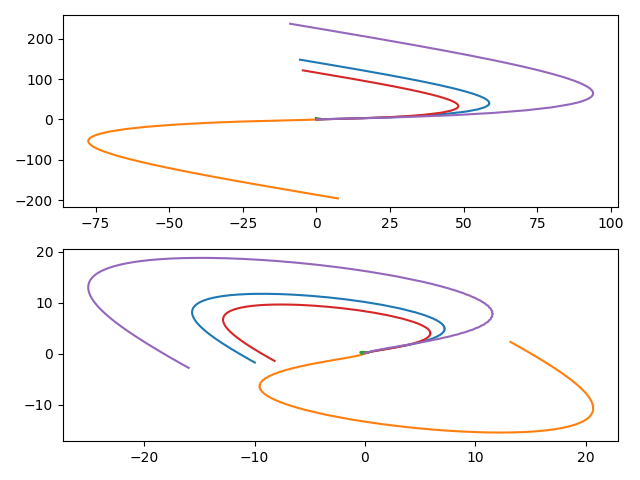

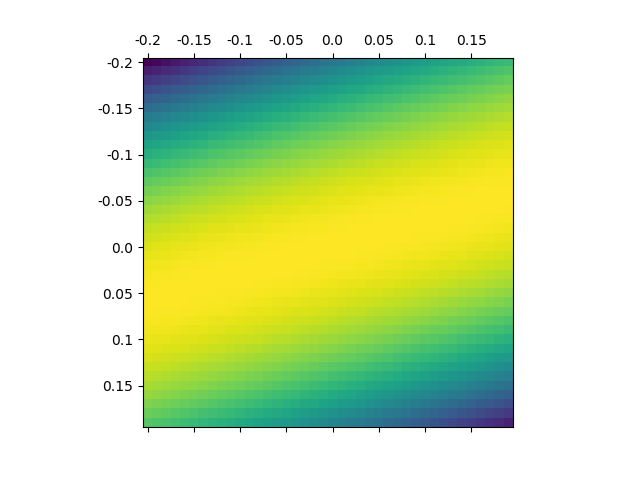

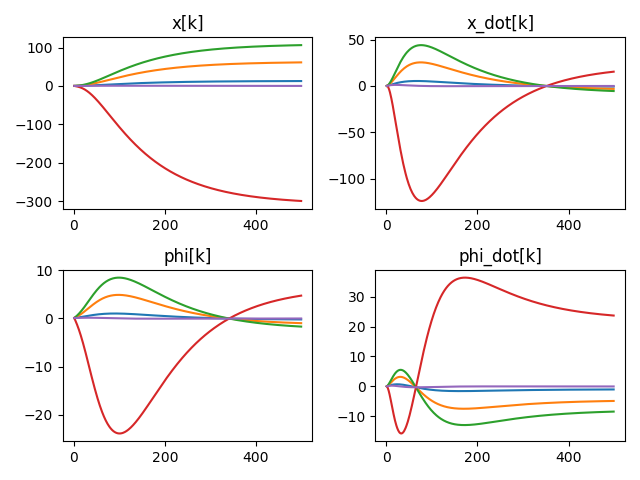

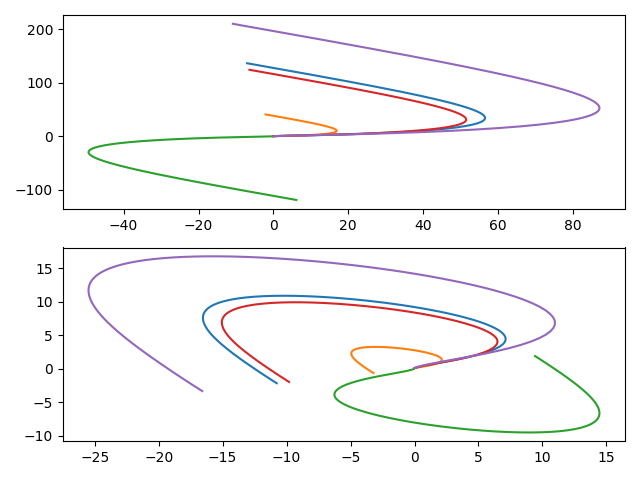

In [47]:
repeate_it(20,0.1)
repeate_it(50,0.1)

#### Task 7
Repeat Tasks 1-6 for $\sigma \in \{0.1, 1\}$, explain your observations

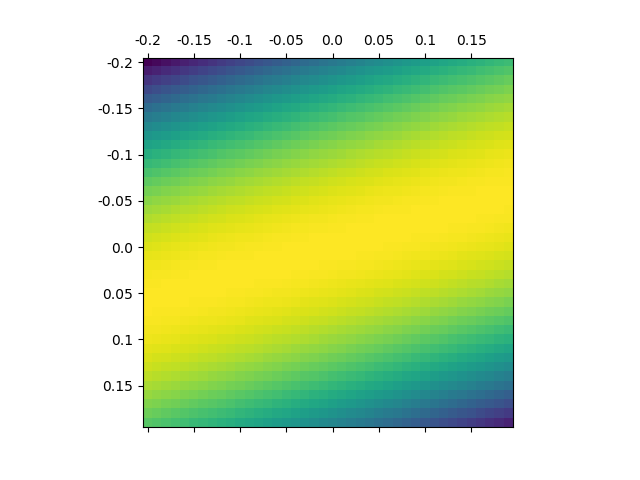

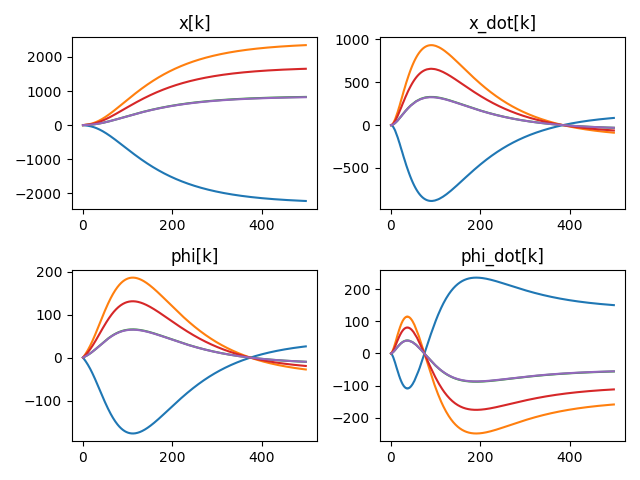

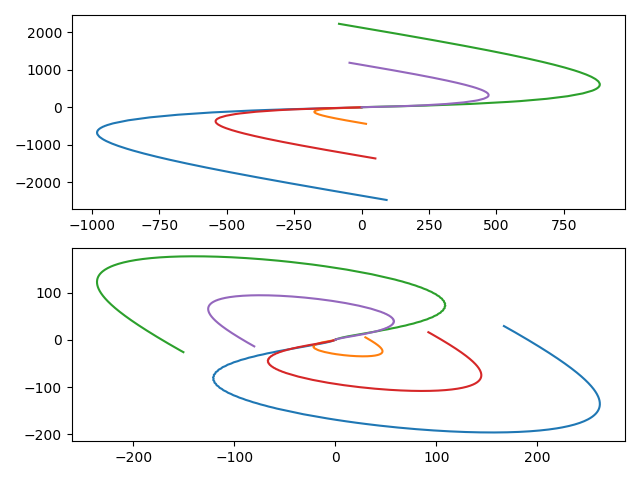

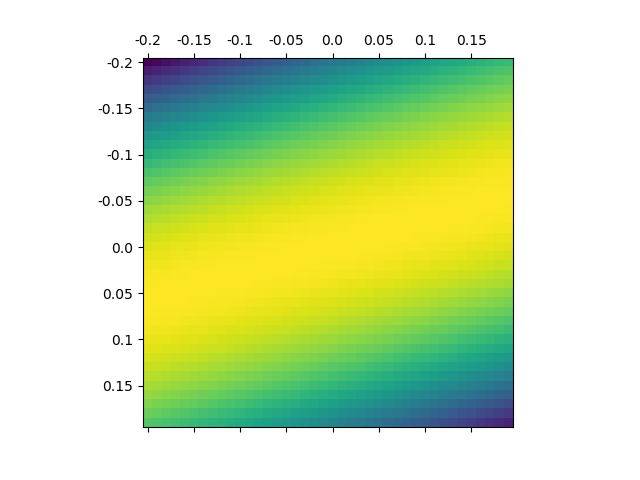

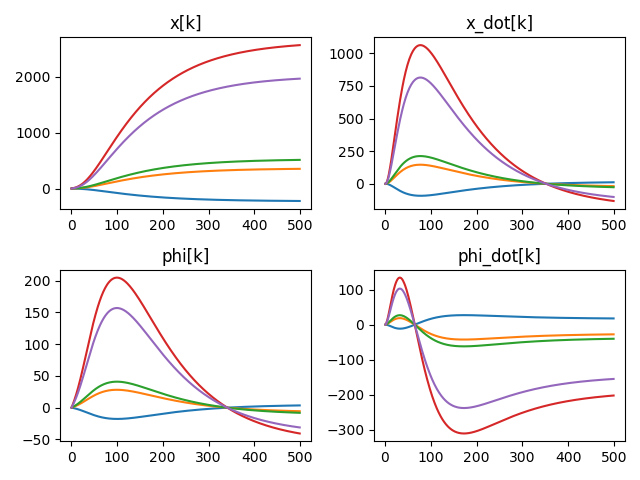

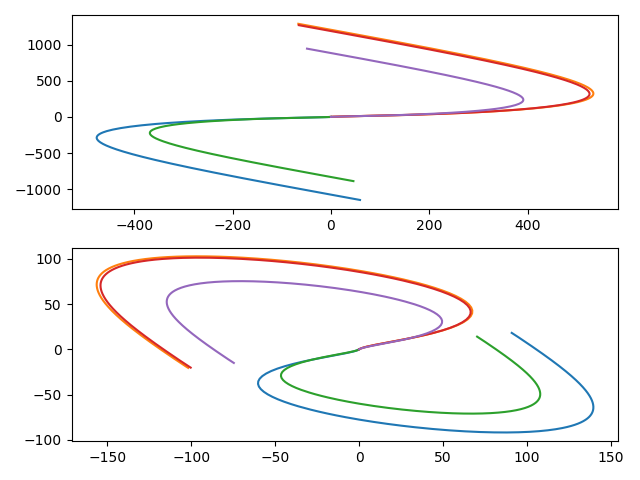

In [48]:
repeate_it(20,1)
repeate_it(50,1)

#### Task 8 
Explain the main differences between the solutions in the tabular case and the continuous case. Address the policy evaluation and value function.

#### ANS Task 8
-> Discrete/tabular MDPs with bounded rewards can be solved exactly through DP(dynamic programming).
-> For such cases, policy evaluation can be done either precisely using matrix inversion or roughly using an iterative technique.
-> By iterating between policy evaluation and policy improvement, policy iteration can be utilized to find the best policies.
-> For continuous case s and a in equation of Uπ(s) are replaced with their vector equivalents, the summation is replaced with an integral, and T provides a probability density rather than a probability mass.
-> For large or continuous problems, we can attempt to find approximate policies represented by parameterized models of the value function.


Note: Pardon for bad or incorrect graphical representation as I have not explored matplotlib and python much, so having some difficulties visualizing plots.